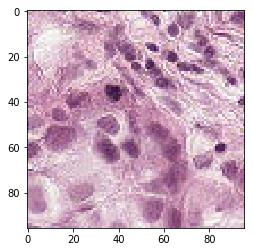

In [13]:
import os
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
%matplotlib inline
vectorized_images = []
directory = os.fsencode('train/')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.tif'):
        with Image.open('train/' + filename) as image:
            vectorized_images.append(np.asarray(image).reshape(27648))
imshow(vectorized_images[0].reshape((96,96,3)))

In [14]:
vec_images = vectorized_images[0]
print(vec_images.reshape(1,27648))
print(vec_images.shape)
print(len(vectorized_images))
for img in vectorized_images[1:2000]:
    vec_images = np.vstack((vec_images,img))
vec_images = vec_images.reshape(2000, 27648).astype(np.float64)

[[227 192 212 ... 210 187 197]]
(27648,)
220025


In [15]:
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import numpy as np
import skcuda.linalg as linalg
from skcuda.linalg import PCA as cuPCA

In [22]:
pca = cuPCA(n_components=100)
X_gpu = gpuarray.GPUArray(vec_images.shape, np.float64, order="F")
X_gpu.set(vec_images)
%time
T_gpu = pca.fit_transform(X_gpu)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs


In [23]:
print(X_gpu)
print(T_gpu)

[[227. 210. 189. ... 140. 198.  73.]
 [192. 204. 196. ...  80. 178. 175.]
 [212. 163. 227. ... 180. 118. 137.]
 ...
 [240. 208. 136. ... 173.  31. 217.]
 [222. 215.  94. ... 203. 129. 143.]
 [183. 216. 142. ... 132. 138. 218.]]
[[-1.19158256e+06  2.28748459e+05 -9.58142697e+03 ...  1.12159435e+02
   1.81039497e+01 -4.54655897e+01]
 [-1.19161888e+06  2.28461774e+05 -9.59693072e+03 ...  2.55025290e+02
   1.15931522e+01 -2.34600995e+02]
 [-1.19162543e+06  2.28231018e+05 -9.47824569e+03 ...  2.72791624e+02
  -7.26540769e+01 -2.00687741e+02]
 ...
 [-1.19637634e+06 -1.97938310e+05 -5.01366767e+04 ...  4.54846495e+02
   1.81884722e+02  1.67760284e+02]
 [-1.19638117e+06 -1.98094989e+05 -5.04099069e+04 ...  4.21530297e+02
   5.02452005e+02  2.85581232e+02]
 [-1.19634943e+06 -1.98270895e+05 -5.05850414e+04 ...  5.68307453e+02
   5.07941576e+02  9.69389794e+01]]
